In [1]:
from collections import defaultdict
from user import *
import random
import msgpack
import glob 
import numpy as np
import io
import os

import msgpack
from twitter_dm.utility.general_utils import mkdir_no_err
from twitter_dm.utility.general_utils import tab_stringify_newline as tsn

from gensim import corpora
from gensim.matutils import corpus2dense

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from pyspark import SparkContext, SparkConf

float_formatter = lambda x: "%.6f" % x
np.set_printoptions(threshold=10000,
                    linewidth=100,
                    formatter={'float_kind':float_formatter})

# create the output directory for these runs
OUTPUT_DIRECTORY = "../output/run_2"
mkdir_no_err(OUTPUT_DIRECTORY)

msgpack_sent_data_dir = os.path.join(OUTPUT_DIRECTORY,"sent_dat")
mkdir_no_err(msgpack_sent_data_dir)

#some constants
MIN_TWEETS_PER_USER = 50
PERCENT_TWEETS_TO_USE_FOR_TEST_DATA = .15

In [2]:
from constraints import IDENTITY_PREFIX
identities = [x.strip() for x in io.open("../data/identity_data/final_identities_list.txt").readlines()]
identity_to_id = {identity : IDENTITY_PREFIX+str(i) for i, identity in enumerate(identities)}
id_to_identity = {v : k for k, v in identity_to_id.items()}

sent_dict = {}
for x in io.open("../data/sentiment_data/clean_epa_terms.txt"):
    x_spl = x.split("\t")
    sent_dict[x_spl[0]] = [float(z) for z in x_spl[1:]]

# Load data

## For the first time

In [3]:
### load in the users
files = glob.glob("../output/textunits/*.mpack")
print len(files)

200


In [5]:
users = []
for i,fil in enumerate(files):
    if i % 100 == 0:
        print i
    users += get_users_from_mpack_fil(fil, MIN_TWEETS_PER_USER, PERCENT_TWEETS_TO_USE_FOR_TEST_DATA, do_random_shuffle=True)
len(users)

0


TypeError: get_users_from_mpack_fil() got an unexpected keyword argument 'do_random_shuffle'

In [ ]:
# construct identity dictionary
texts = [u.all_identities for u in users]
dictionary = corpora.Dictionary(texts) 
print dictionary
training_corpus = [dictionary.doc2bow(u.training_id) for u in users]
training_corpus_matrix = corpus2dense(training_corpus,len(dictionary))
test_corpus = [dictionary.doc2bow(u.test_id) for u in users]
test_corpus_matrix = corpus2dense(test_corpus,len(dictionary))
for i,u in enumerate(users):
    u.training_vector = training_corpus_matrix[:,i]
    u.test_vector = test_corpus_matrix[:,i]

In [ ]:
full_users = users

In [ ]:
# The association model estimation appears to be unstable for users w/ < 175 or so observations,
# so remove these users from the data
users =[u for u in users if u.training_vector.sum() > 175]
len(full_users), len(users)

In [ ]:
# finally, we can now cache the users for future analysis/ if something weird happens
dump_users(users, OUTPUT_DIRECTORY)

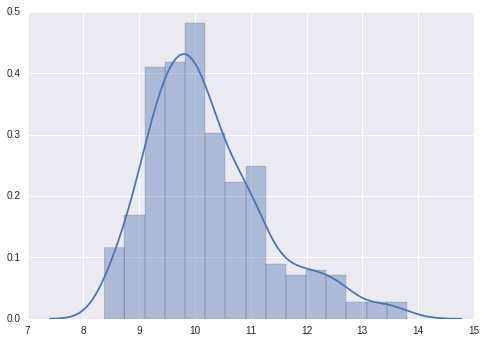

In [17]:
import seaborn as sns
tv = np.array([u.training_vector for u in users])
%matplotlib inline
sns.set()
print tv.sum(axis=0).min(), np.median(tv.sum(axis=0))
sns.distplot(np.log(tv.sum(axis=0)))


In [ ]:
np.save("run_1_user_id_matrix",tv)

In [18]:
# put together some more indexes
index_to_id = {k : v for k,v in dictionary.items()}
id_to_index = {v : k for k,v in dictionary.items()}
index_to_identity = {k : id_to_identity[v] for k, v in dictionary.items()}

# write out the index for analysis
out_ind_id = io.open(os.path.join(OUTPUT_DIRECTORY,"index_to_identity_final.tsv"),"w")
for k, v in index_to_identity.items():
    out_ind_id.write(unicode(k) + "\t" + v + "\n")
out_ind_id.close()

out_ind_id = io.open(os.path.join(OUTPUT_DIRECTORY,"index_to_id_final.tsv"),"w")
for k, v in index_to_id.items():
    out_ind_id.write(unicode(k) + "\t" + v + "\n")
out_ind_id.close()

## Reload

In [3]:
users = list(load_users(OUTPUT_DIRECTORY))

index_to_identity = {int(line.split("\t")[0]) : line.strip().split("\t")[1] 
               for line in open(os.path.join(OUTPUT_DIRECTORY,"index_to_identity_final.tsv")) }

index_to_id = {k:identity_to_id[v] for k, v in index_to_identity.items()}
id_to_index = {v : k for k,v in index_to_id.items()}

loading user data...
 ... 
 loaded! 


# Set identity sentiment values

In [19]:
import pandas as pd
sent_dict['nerd'] = [0.337138927097661,1.54855305466238,-0.326494345718901]
sent_dict['geek'] = [1.13780012584526,0.771012312261079,-1.15146349297431]

# for those we have in our dictionarys, we can just use that
identity_values = {k : sent_dict[v] for k,v in id_to_identity.items() if v in sent_dict}
# for those we dont, we use empirical priors, generated from a 1% sample - see gen_empirical_priors_unk.py
empirical_prior_data = pd.read_csv("../data/sentiment_data/data_for_empirical_priors.tsv", header=None,sep="\t")
empirical_prior_data.columns= ['user','word','epa','total_sent','n_tweets']

# make sure we're getting everything
identities_with_no_values = set([x for x in id_to_identity.values() if x not in sent_dict])
identities_in_empirical = set(empirical_prior_data.word.unique().tolist())
print identities_with_no_values - identities_in_empirical

set([])


In [20]:
# not a lot of tweets for the prior but good enough
k = empirical_prior_data.groupby(['word']).apply(lambda x: x['n_tweets'].sum()/3)
# print k 

# do empirical bayes ish for these priors ...
dat = empirical_prior_data.groupby(['word','epa']).apply(lambda x: np.mean(x['total_sent']/x['n_tweets'])).reset_index()
dat.columns = ['word','epa','value']
# do some linear transformations to correct for known biases between survey and sentiment model

dat['e_trans'] = (dat[dat.epa =='e'].value - .18) * 4.3 / np.max(np.abs(dat[dat.epa=='e'].value))
dat['p_trans'] = (dat[dat.epa =='p'].value - .56) * 4.3 / np.max(np.abs(dat[dat.epa=='p'].value))
dat['a_trans'] = (dat[dat.epa =='a'].value +.57) * 4.3 / np.max(np.abs(dat[dat.epa=='a'].value))

for identity in identities_with_no_values:
    id = identity_to_id[identity]
    e = dat.ix[(dat.word == identity) & (dat.epa == 'e')].e_trans.tolist()[0]
    p = dat.ix[(dat.word == identity) & (dat.epa == 'p')].p_trans.tolist()[0]
    a = dat.ix[(dat.word == identity) & (dat.epa == 'a')].a_trans.tolist()[0]
    identity_values[id]= [e,p,a]

# Write out raw text for Vader baseline sentiment model

In [21]:
# write out the raw text so we can build the baseline sentiment model elsewhere
training_raw_text_out = io.open(os.path.join(OUTPUT_DIRECTORY, "training_raw_text_fin.txt"),"w")
for j, u in enumerate(users):
    if j % 10000 == 0:
        print j
    uid = u.uid
    for i, raw_text in enumerate(u.training_raw_text):
        training_raw_text_out.write(tsn([uid,
                                         u",".join(u.training_identities_per_tweet[i]),
                                         raw_text.decode("utf8")]))
training_raw_text_out.close()

0
10000
20000
30000
40000


# Deal w/ pyspark pickling issues

In [22]:
# because pyspark uses pickle, which is really slow for this data, we cache data on disk ourselves using msgpack
# in practice this is infinitely more efficient, although theoretically it should be slower
spl_inds = np.array_split(np.array(range(len(users))),256)

last_spl = 0
for i, inds in enumerate(spl_inds):
    max_spl_inds = last_spl + len(inds)
    for q, name in [[[u.training_id_to_tweets for u in users[last_spl:max_spl_inds]], 'tr_inds'],
                    [[u.training_deflection_strings  for u in users[last_spl:max_spl_inds]], "tr_def_str" ],
                    [[u.test_deflection_strings  for u in users[last_spl:max_spl_inds]], "tes_def_str"],
                    [[u.training_identities_per_tweet  for u in users[last_spl:max_spl_inds]],'tr_id_per_tw'],
                    [[u.test_identities_per_tweet  for u in users[last_spl:max_spl_inds]],'tes_id_per_tw']
                   ]:
        msgpack.dump(q, open(os.path.join(msgpack_sent_data_dir,name+str(i)+".mpack"),"wb"))

    if i % 50 == 0:
        print i
    last_spl = max_spl_inds

0
50
100
150
200
250


# Run the models

In [46]:
# load up spark
conf = (SparkConf().setMaster("local[*]").setAppName("My app")
        .set("spark.local.dir", "/usr1/kjoseph/spark_tmp")
        .set("spark.driver.maxResultSize", "40g"))
sc = SparkContext(conf=conf)

In [32]:
import sentiment_model
sentiment_model = reload(sentiment_model)
sm = sentiment_model.SentimentModel(len(users), index_to_id, identity_values,kappa=300.,nu=3000.)
sent_output_dir = os.path.join(OUTPUT_DIRECTORY,"sent_res_final")
mkdir_no_err(sent_output_dir)

done computing mu0
got phi


### TO RELOAD PREVIOUS SENTIMENT MODEL

In [ ]:
sm = sentiment_model.SentimentModel(len(users), index_to_id, identity_values,kappa=100.,nu=1000)

iteration = str(250)

basic_info = msgpack.load(open(os.path.join(OUTPUT_DIRECTORY,"sent_res_final",iteration+"_sent_basic.mpack"))

mu = np.load(os.path.join(OUTPUT_DIRECTORY,"sent_res_final",iteration+"_sent_mu.npy"))
phi = np.load(os.path.join(OUTPUT_DIRECTORY,"sent_res_final",iteration+"_sent_phi.npy"))
prec_mat = np.load(os.path.join(OUTPUT_DIRECTORY,"sent_res_final",iteration+"_sent_precision_matrix.npy"))
sigma = np.load(os.path.join(OUTPUT_DIRECTORY,"sent_res_final",iteration+"_sent_sigma.npy"))
sigma0 = np.load(os.path.join(OUTPUT_DIRECTORY,"sent_res_final","sent_sigma_0.npy"))
mu=  np.load(os.path.join(OUTPUT_DIRECTORY,"sent_res_final","sent_mu_0.npy"))

sm.kappa = basic_info['kappa']
sm.iteration = basic_info['iteration']
sm.index_to_ids = basic_info['index_to_ids']
sm.beta = basic_info['beta']
sm.ids_to_index = basic_info['ids_to_index']
sm.n_identity_sent_values = basic_info['n_identity_sent_values ']
sm.nu = basic_info['nu']
sm.identity_to_values_small = basic_info['identity_to_values_small']
sm.mu = mu
sm.phi = phi    
sm.precision_matrix = prec_mat
sm.sigma = sigma
sm.sigma_0 = sigma0

### Run sentiment model

In [33]:
sm.iteration = 0

In [ ]:
# initialize the models

# after about 300 iterations the model's perplexity stabilizes, so we quit.
for i in range(500):
    print i, sm.iteration
    if i % 50 == 0:
        sm.dump(sent_output_dir)
    #if i > 500:
    np.save(os.path.join(sent_output_dir,str(sm.iteration)+"_mu"), sm.mu)
    sm.iterate(sc,spl_inds,msgpack_sent_data_dir,id_to_index )

sm.dump(sent_output_dir)

In [35]:
print sm.iteration

500


## Association Model

In [38]:
import association_model
association_model = reload(association_model)
am = association_model.AssociationModel(users,len(id_to_index))
assoc_output_dir = os.path.join(OUTPUT_DIRECTORY,"assoc_res_final")
mkdir_no_err(assoc_output_dir)

### To reload previous association model

In [7]:
# reload assoc model
am = association_model.AssociationModel(users,len(id_to_index))

iteration = str(883)

basic_info = msgpack.load(open(os.path.join(OUTPUT_DIRECTORY,"assoc_res_final",iteration+"_assoc_basic.mpack")))

mu = np.load(os.path.join(OUTPUT_DIRECTORY,"assoc_res_final",iteration+"_assoc_mu.npy"))
eta = np.load(os.path.join(OUTPUT_DIRECTORY,"assoc_res_final",iteration+"_assoc_eta.npy"))
prec_mat = np.load(os.path.join(OUTPUT_DIRECTORY,"assoc_res_final",iteration+"_assoc_precision_matrix.npy"))
sigma = np.load(os.path.join(OUTPUT_DIRECTORY,"assoc_res_final",iteration+"_assoc_sigma.npy"))
W = np.load(os.path.join(OUTPUT_DIRECTORY,"assoc_res_final","assoc_W.npy"))
mu0=  np.load(os.path.join(OUTPUT_DIRECTORY,"assoc_res_final","assoc_mu_0.npy"))

am.iteration = basic_info['iteration']
am.mu = mu
am.eta = eta
am.precision_matrix = prec_mat
am.sigma = sigma
am.W = W

In [8]:
print am.iteration

883


## Run association model

In [ ]:
# initialize the models 
## after about 300 iterations the LL starts to increase ... indicates its doing some kind of overfitting

for i in range(175):
    print i 
    if am.iteration % 50 == 0:
        am.dump(assoc_output_dir)
    #if i > 300:
    np.save(os.path.join(assoc_output_dir,str(am.iteration)+"_mu"), am.mu)
    am.iterate(sc,256)

am.dump(assoc_output_dir)

0
ASSOC MODEL LL TRAINING, TEST  -10691004.2824 , -4774869.87562
1

In [48]:
sc.stop()